# deep learning from scratch using pytorch 

In [1]:
#import libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from tensorflow.keras.utils import to_categorical
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
class Data:
    def __init__(self,path,target):
        self.path=path
        self.X_train=None
        self.y_train=None
        self.X_val=None
        self.y_val=None
        self.X_test=None
        self.y_test=None
        self.target=target
        self.features_name=[]
    def display(self):
        df=pd.read_csv(self.path)
        print(df.info())
    def LoadProcess(self):
        df=pd.read_csv(self.path)
        categorical=df.dtypes[df.dtypes=='object']
        for i in categorical.index:
            self.features_name.append(i)
        le=LabelEncoder()
        for i in self.features_name:
            df[i]=le.fit_transform(df[i])

        
        X=df.drop(self.target,axis=1)
        y=df[self.target]
        # standardize the features
        scaler=StandardScaler()
        X=scaler.fit_transform(X)
        #y_encoded=to_categorical(y)
        X_tensor=torch.tensor(X,dtype=torch.float32)
        y_tensor=torch.tensor(y,dtype=torch.long)
         # Split the data into training and testing sets
        X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
        # Further split the temporary set into validation and test sets
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        self.X_train = X_train
        self.y_train = y_train
        # Split the data into training and testing sets
        #self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
        #return self.X_train,self.X_test,self.y_train,self.y_test



        

In [3]:
df=pd.read_csv("diagnosed_cbc_data_v4.csv")
df['Diagnosis'].nunique()

9

In [4]:
dataset = Data("diagnosed_cbc_data_v4.csv","Diagnosis")
dataset.display()
dataset.LoadProcess()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281 entries, 0 to 1280
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WBC        1281 non-null   float64
 1   LYMp       1281 non-null   float64
 2   NEUTp      1281 non-null   float64
 3   LYMn       1281 non-null   float64
 4   NEUTn      1281 non-null   float64
 5   RBC        1281 non-null   float64
 6   HGB        1281 non-null   float64
 7   HCT        1281 non-null   float64
 8   MCV        1281 non-null   float64
 9   MCH        1281 non-null   float64
 10  MCHC       1281 non-null   float64
 11  PLT        1281 non-null   float64
 12  PDW        1281 non-null   float64
 13  PCT        1281 non-null   float64
 14  Diagnosis  1281 non-null   object 
dtypes: float64(14), object(1)
memory usage: 150.2+ KB
None


## MLP

In [5]:
class Layer:
    def __init__(self,num_inputs,num_neurons):
        self.w=torch.nn.init.xavier_uniform(torch.randn(num_inputs,num_neurons,requires_grad=True))
        self.b=torch.zeros(num_neurons, requires_grad=True)# a bias for each neuron in the layer  
        

    def forward(self,inputs):
        return torch.mm(inputs,self.w)+self.b

    
    def activation_relu(input):
        return torch.maximum(input,torch.tensor(0.0))

    
    def softmax(logits):
        exp_logits = torch.exp(logits)
        sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
        return exp_logits / sum_exp_logits


    
    def cross_entropy(predicted, target):
        log_likelihood = -torch.log(predicted[range(len(predicted)), target])
        return torch.mean(log_likelihood)

    
    def backward(self,predicted,y):
        loss=Layer.cross_entropy(predicted,y)
        loss.backward()
        return loss.item()

    
    def update(self,lr):
        with torch.no_grad():
            self.w -= lr * self.w.grad
            self.b -= lr * self.b.grad
            self.w.grad.zero_()
            self.b.grad.zero_()


In [6]:
class MultiLayerPreceptron:
    
    def __init__(self,input_size,hidden_size_1,hidden_size_2,output_size):
        #self.flatten=Flatten_layer()
        self.input_layer=Layer(input_size,hidden_size_1)
        self.hidden_layer_1=Layer(hidden_size_1,hidden_size_2)
        self.hidden_layer_2=Layer(hidden_size_2,output_size)

    
    def forward(self, x):
        #x=self.flatten.forward(x)
        x=self.input_layer.forward(x)
        x=Layer.activation_relu(x)
        x=self.hidden_layer_1.forward(x)
        x=Layer.activation_relu(x)
        x=self.hidden_layer_2.forward(x)
        x=Layer.softmax(x)
        return x

    
    def backward(self, predicted,target,lr):
        loss=self.hidden_layer_2.backward(predicted,target)
        # update the paramaters
        self.input_layer.update(lr)
        self.hidden_layer_1.update(lr)
        self.hidden_layer_2.update(lr)
        return loss

    
    def train(self,X_train,y_train,X_val,y_val,lr,num_epochs=100):
        print(lr)
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        train_precisions = []
        val_precisions = []
        train_recalls = []
        val_recalls = []
        train_f1s = []
        val_f1s = []
        for epoch in range(num_epochs):
            predictions = self.forward(X_train)
            loss = self.backward(predictions, y_train, lr)
            train_losses.append(loss)
            train_accuracy = accuracy_score(y_train, predictions.argmax(1))
            train_accuracies.append(train_accuracy)
            train_precision = precision_score(y_train, predictions.argmax(1), average='weighted')
            train_precisions.append(train_precision)
            train_recall = recall_score(y_train, predictions.argmax(1), average='weighted')
            train_recalls.append(train_recall)
            train_f1 = f1_score(y_train, predictions.argmax(1), average='weighted')
            train_f1s.append(train_f1)
            # validation
            with torch.no_grad():
                y_val_pred = self.forward(X_val)
                val_loss = Layer.cross_entropy(y_val_pred, y_val).item()
                val_losses.append(val_loss)
                val_accuracy = accuracy_score(y_val, y_val_pred.argmax(1))
                val_accuracies.append(val_accuracy)
                val_precision = precision_score(y_val, y_val_pred.argmax(1), average='weighted')
                val_precisions.append(val_precision)
                val_recall = recall_score(y_val, y_val_pred.argmax(1), average='weighted')
                val_recalls.append(val_recall)
                val_f1 = f1_score(y_val, y_val_pred.argmax(1), average='weighted')
                val_f1s.append(val_f1)
            
            if(epoch+1)% 1000==0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')
        print(f'Final Training Loss: {train_losses[-1]:.4f}')
        print(f'Final Validation Loss: {val_losses[-1]:.4f}')
        print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
        print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')
        print(f'Final Training Precision: {train_precisions[-1]:.4f}')
        print(f'Final Validation Precision: {val_precisions[-1]:.4f}')
        print(f'Final Training Recall: {train_recalls[-1]:.4f}')
        print(f'Final Validation Recall: {val_recalls[-1]:.4f}')
        print(f'Final Training F1 Score: {train_f1s[-1]:.4f}')
        print(f'Final Validation F1 Score: {val_f1s[-1]:.4f}')
        self.plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, 
                                  train_precisions, val_precisions, train_recalls, val_recalls, 
                                  train_f1s, val_f1s)
                    
    def evaluate(self,X_test,y_test):
        all_preds=[]
        all_labels=[]
        with torch.no_grad():           
            outputs=self.forward(X_test)
            _,preds=torch.max(outputs,1)
            all_preds.append(preds)
            all_preds=torch.cat(all_preds,dim=0)

            accuracy = accuracy_score(y_test.numpy(), all_preds.numpy())
            precision = precision_score(y_test.numpy(), all_preds.numpy(), average='macro',zero_division=0)
            recall = recall_score(y_test.numpy(), all_preds.numpy(), average='macro',zero_division=0)
            f1 = f1_score(y_test.numpy(), all_preds.numpy(), average='macro',zero_division=0)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            # Confusion Matrix
            conf_matrix = confusion_matrix(y_test.numpy(), all_preds.numpy(),labels=np.arange(9))
            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
    
    
    def plot_learning_curves(self, train_losses, val_losses, train_accuracies, val_accuracies, 
                             train_precisions, val_precisions, train_recalls, val_recalls, 
                             train_f1s, val_f1s):
        epochs = range(1, len(train_losses) + 1)
        
        plt.figure(figsize=(18, 10))
        
        # Plot Loss
        plt.subplot(2, 3, 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        
        # Plot Accuracy
        plt.subplot(2, 3, 2)
        plt.plot(epochs, train_accuracies, label='Training Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        
        # Plot Precision
        plt.subplot(2, 3, 3)
        plt.plot(epochs, train_precisions, label='Training Precision')
        plt.plot(epochs, val_precisions, label='Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
        plt.title('Training and Validation Precision')
        
        # Plot Recall
        plt.subplot(2, 3, 4)
        plt.plot(epochs, train_recalls, label='Training Recall')
        plt.plot(epochs, val_recalls, label='Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.title('Training and Validation Recall')
        
        # Plot F1 Score
        plt.subplot(2, 3, 5)
        plt.plot(epochs, train_f1s, label='Training F1 Score')
        plt.plot(epochs, val_f1s, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title('Training and Validation F1 Score')
        
        plt.tight_layout()
        plt.show()

In [7]:
class MultiLayerPreceptron3:
    
    def __init__(self,input_size,hidden_size_1,hidden_size_2,hidden_size_3,output_size):
        #self.flatten=Flatten_layer()
        self.input_layer=Layer(input_size,hidden_size_1)
        self.hidden_layer_1=Layer(hidden_size_1,hidden_size_2)
        self.hidden_layer_2=Layer(hidden_size_2,hidden_size_3)
        self.hidden_layer_3=Layer(hidden_size_3,output_size)

    
    def forward(self, x):
        #x=self.flatten.forward(x)
        x=self.input_layer.forward(x)
        x=Layer.activation_relu(x)
        x=self.hidden_layer_1.forward(x)
        x=Layer.activation_relu(x)
        x=self.hidden_layer_2.forward(x)
        x=self.hidden_layer_3.forward(x)
        x=Layer.activation_relu(x)
        x=Layer.softmax(x)
        return x

    
    def backward(self, predicted,target,lr):
        loss=self.hidden_layer_3.backward(predicted,target)
        # update the paramaters
        self.input_layer.update(lr)
        self.hidden_layer_1.update(lr)
        self.hidden_layer_2.update(lr)
        self.hidden_layer_3.update(lr)
        return loss

    
    def train(self,X_train,y_train,X_val,y_val,lr,num_epochs=100):
        print(lr)
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        train_precisions = []
        val_precisions = []
        train_recalls = []
        val_recalls = []
        train_f1s = []
        val_f1s = []
        for epoch in range(num_epochs):
            predictions = self.forward(X_train)
            loss = self.backward(predictions, y_train, lr)
            train_losses.append(loss)
            train_accuracy = accuracy_score(y_train, predictions.argmax(1))
            train_accuracies.append(train_accuracy)
            train_precision = precision_score(y_train, predictions.argmax(1), average='weighted')
            train_precisions.append(train_precision)
            train_recall = recall_score(y_train, predictions.argmax(1), average='weighted')
            train_recalls.append(train_recall)
            train_f1 = f1_score(y_train, predictions.argmax(1), average='weighted')
            train_f1s.append(train_f1)
            # validation
            with torch.no_grad():
                y_val_pred = self.forward(X_val)
                val_loss = Layer.cross_entropy(y_val_pred, y_val).item()
                val_losses.append(val_loss)
                val_accuracy = accuracy_score(y_val, y_val_pred.argmax(1))
                val_accuracies.append(val_accuracy)
                val_precision = precision_score(y_val, y_val_pred.argmax(1), average='weighted')
                val_precisions.append(val_precision)
                val_recall = recall_score(y_val, y_val_pred.argmax(1), average='weighted')
                val_recalls.append(val_recall)
                val_f1 = f1_score(y_val, y_val_pred.argmax(1), average='weighted')
                val_f1s.append(val_f1)
            
            if(epoch+1)% 1000==0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')
        print(f'Final Training Loss: {train_losses[-1]:.4f}')
        print(f'Final Validation Loss: {val_losses[-1]:.4f}')
        print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
        print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')
        print(f'Final Training Precision: {train_precisions[-1]:.4f}')
        print(f'Final Validation Precision: {val_precisions[-1]:.4f}')
        print(f'Final Training Recall: {train_recalls[-1]:.4f}')
        print(f'Final Validation Recall: {val_recalls[-1]:.4f}')
        print(f'Final Training F1 Score: {train_f1s[-1]:.4f}')
        print(f'Final Validation F1 Score: {val_f1s[-1]:.4f}')
        self.plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, 
                                  train_precisions, val_precisions, train_recalls, val_recalls, 
                                  train_f1s, val_f1s)
                    
    def evaluate(self,X_test,y_test):
        all_preds=[]
        all_labels=[]
        with torch.no_grad():           
            outputs=self.forward(X_test)
            _,preds=torch.max(outputs,1)
            all_preds.append(preds)
            all_preds=torch.cat(all_preds,dim=0)

            accuracy = accuracy_score(y_test.numpy(), all_preds.numpy())
            precision = precision_score(y_test.numpy(), all_preds.numpy(), average='macro',zero_division=0)
            recall = recall_score(y_test.numpy(), all_preds.numpy(), average='macro',zero_division=0)
            f1 = f1_score(y_test.numpy(), all_preds.numpy(), average='macro',zero_division=0)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            conf_matrix = confusion_matrix(y_test.numpy(), all_preds.numpy(),labels=np.arange(9))
            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()

      
            
    def plot_learning_curves(self, train_losses, val_losses, train_accuracies, val_accuracies, 
                             train_precisions, val_precisions, train_recalls, val_recalls, 
                             train_f1s, val_f1s):
        epochs = range(1, len(train_losses) + 1)
        
        plt.figure(figsize=(18, 10))
        
        # Plot Loss
        plt.subplot(2, 3, 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        
        # Plot Accuracy
        plt.subplot(2, 3, 2)
        plt.plot(epochs, train_accuracies, label='Training Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        
        # Plot Precision
        plt.subplot(2, 3, 3)
        plt.plot(epochs, train_precisions, label='Training Precision')
        plt.plot(epochs, val_precisions, label='Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
        plt.title('Training and Validation Precision')
        
        # Plot Recall
        plt.subplot(2, 3, 4)
        plt.plot(epochs, train_recalls, label='Training Recall')
        plt.plot(epochs, val_recalls, label='Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.title('Training and Validation Recall')
        
        # Plot F1 Score
        plt.subplot(2, 3, 5)
        plt.plot(epochs, train_f1s, label='Training F1 Score')
        plt.plot(epochs, val_f1s, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title('Training and Validation F1 Score')
        
        plt.tight_layout()
        plt.show()
     

In [8]:
dataset.y_test

tensor([6, 1, 5, 0, 5, 1, 3, 6, 2, 1, 0, 0, 5, 1, 6, 8, 5, 8, 1, 6, 5, 5, 1, 0,
        6, 0, 7, 5, 5, 0, 5, 0, 0, 0, 6, 2, 0, 0, 2, 0, 5, 1, 5, 6, 1, 0, 0, 5,
        1, 5, 0, 1, 5, 0, 8, 1, 0, 1, 0, 0, 0, 0, 6, 5, 6, 8, 6, 1, 6, 0, 6, 0,
        5, 1, 5, 7, 6, 0, 0, 8, 5, 5, 0, 1, 8, 0, 0, 8, 6, 8, 0, 0, 5, 0, 2, 5,
        5, 3, 0, 5, 0, 1, 0, 0, 0, 5, 5, 0, 1, 1, 0, 5, 0, 0, 0, 1, 6, 5, 7, 0,
        0, 5, 0, 3, 6, 6, 7, 6, 6])

# layers=2 , num_neurons=[16,16] ,lr=0.01

In [9]:
input_size=dataset.X_train.shape[1]
hidden_size_1=16
hidden_size_2=16
output_size=len(torch.unique(dataset.y_train))

0.001
Epoch [1000/10000], Loss: 2.0765
Epoch [2000/10000], Loss: 1.9335
Epoch [3000/10000], Loss: 1.8195
Epoch [4000/10000], Loss: 1.7148
Epoch [5000/10000], Loss: 1.6189
Epoch [6000/10000], Loss: 1.5319
Epoch [7000/10000], Loss: 1.4541
Epoch [8000/10000], Loss: 1.3849
Epoch [9000/10000], Loss: 1.3237
Epoch [10000/10000], Loss: 1.2703
Final Training Loss: 1.2703
Final Validation Loss: 1.1960
Final Training Accuracy: 0.5820
Final Validation Accuracy: 0.6250
Final Training Precision: 0.5428
Final Validation Precision: 0.6026
Final Training Recall: 0.5820
Final Validation Recall: 0.6250
Final Training F1 Score: 0.5451
Final Validation F1 Score: 0.5869


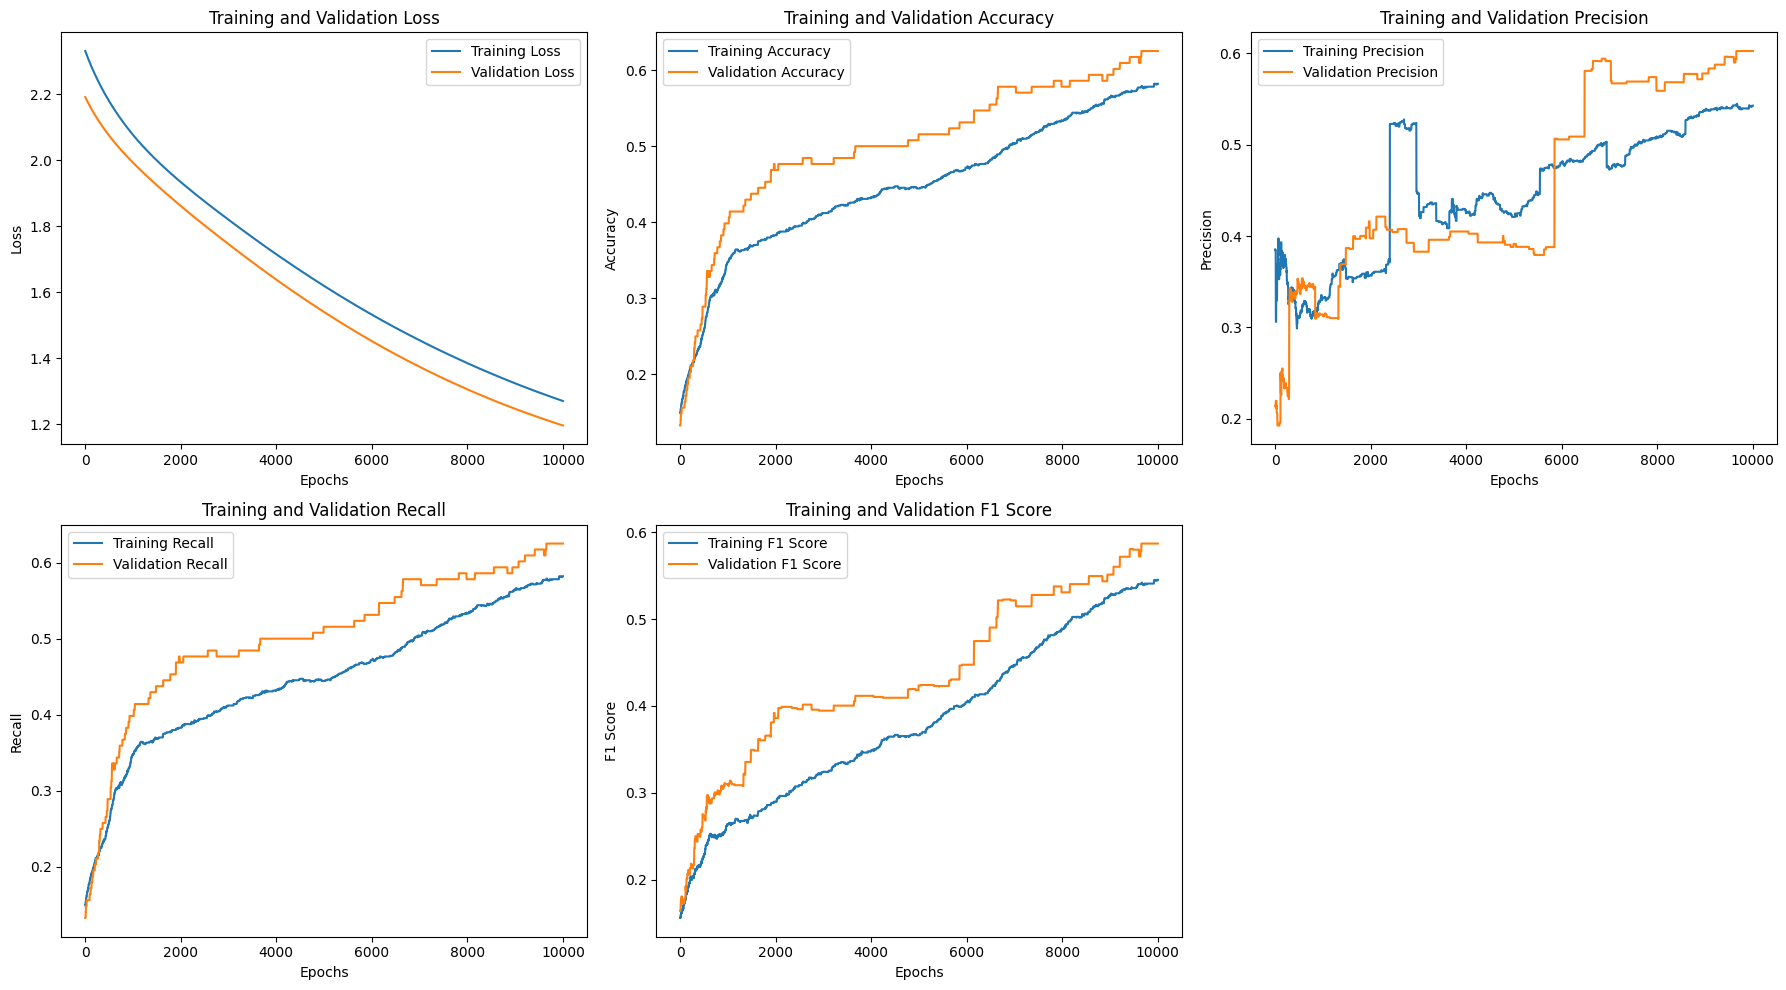

Accuracy: 0.5969
Precision: 0.3769
Recall: 0.3557
F1 Score: 0.3558


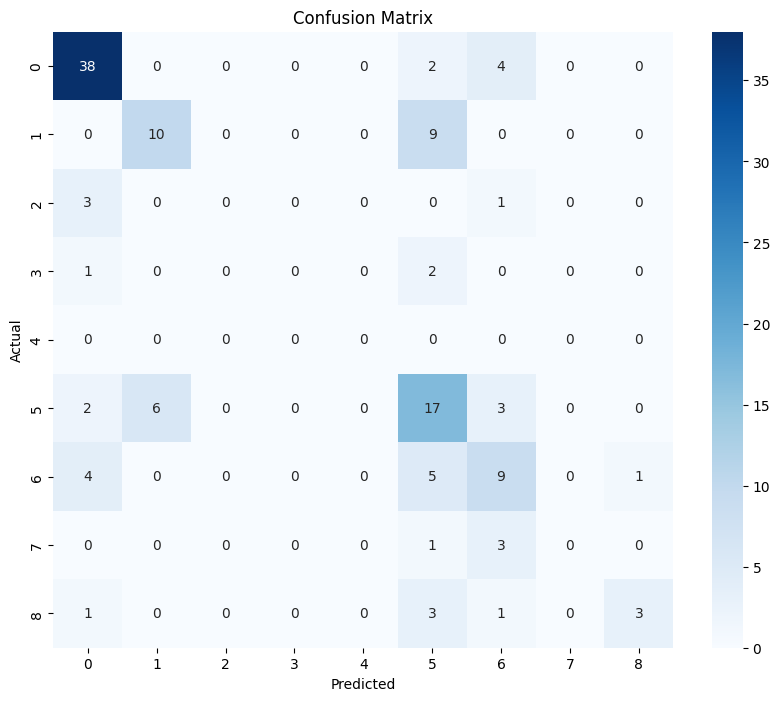

In [10]:
# Instantiate the model
model = MultiLayerPreceptron(input_size, hidden_size_1, hidden_size_2, output_size)

# Train the model
model.train(dataset.X_train,dataset.y_train,dataset.X_val,dataset.y_val, num_epochs=10000,lr=0.001)

# Evaluate the model
model.evaluate(dataset.X_test,dataset.y_test)

# layers 2, num neurons=[64,64] , lr=0.01

In [11]:
input_size2=dataset.X_train.shape[1]
hidden_size2_1=64
hidden_size2_2=64
output_size2=len(torch.unique(dataset.y_train))

0.001
Epoch [1000/10000], Loss: 1.9588
Epoch [2000/10000], Loss: 1.7613
Epoch [3000/10000], Loss: 1.5899
Epoch [4000/10000], Loss: 1.4421
Epoch [5000/10000], Loss: 1.3222
Epoch [6000/10000], Loss: 1.2271
Epoch [7000/10000], Loss: 1.1496
Epoch [8000/10000], Loss: 1.0840
Epoch [9000/10000], Loss: 1.0266
Epoch [10000/10000], Loss: 0.9756
Final Training Loss: 0.9756
Final Validation Loss: 0.9693
Final Training Accuracy: 0.7344
Final Validation Accuracy: 0.7031
Final Training Precision: 0.7253
Final Validation Precision: 0.5986
Final Training Recall: 0.7344
Final Validation Recall: 0.7031
Final Training F1 Score: 0.7008
Final Validation F1 Score: 0.6418


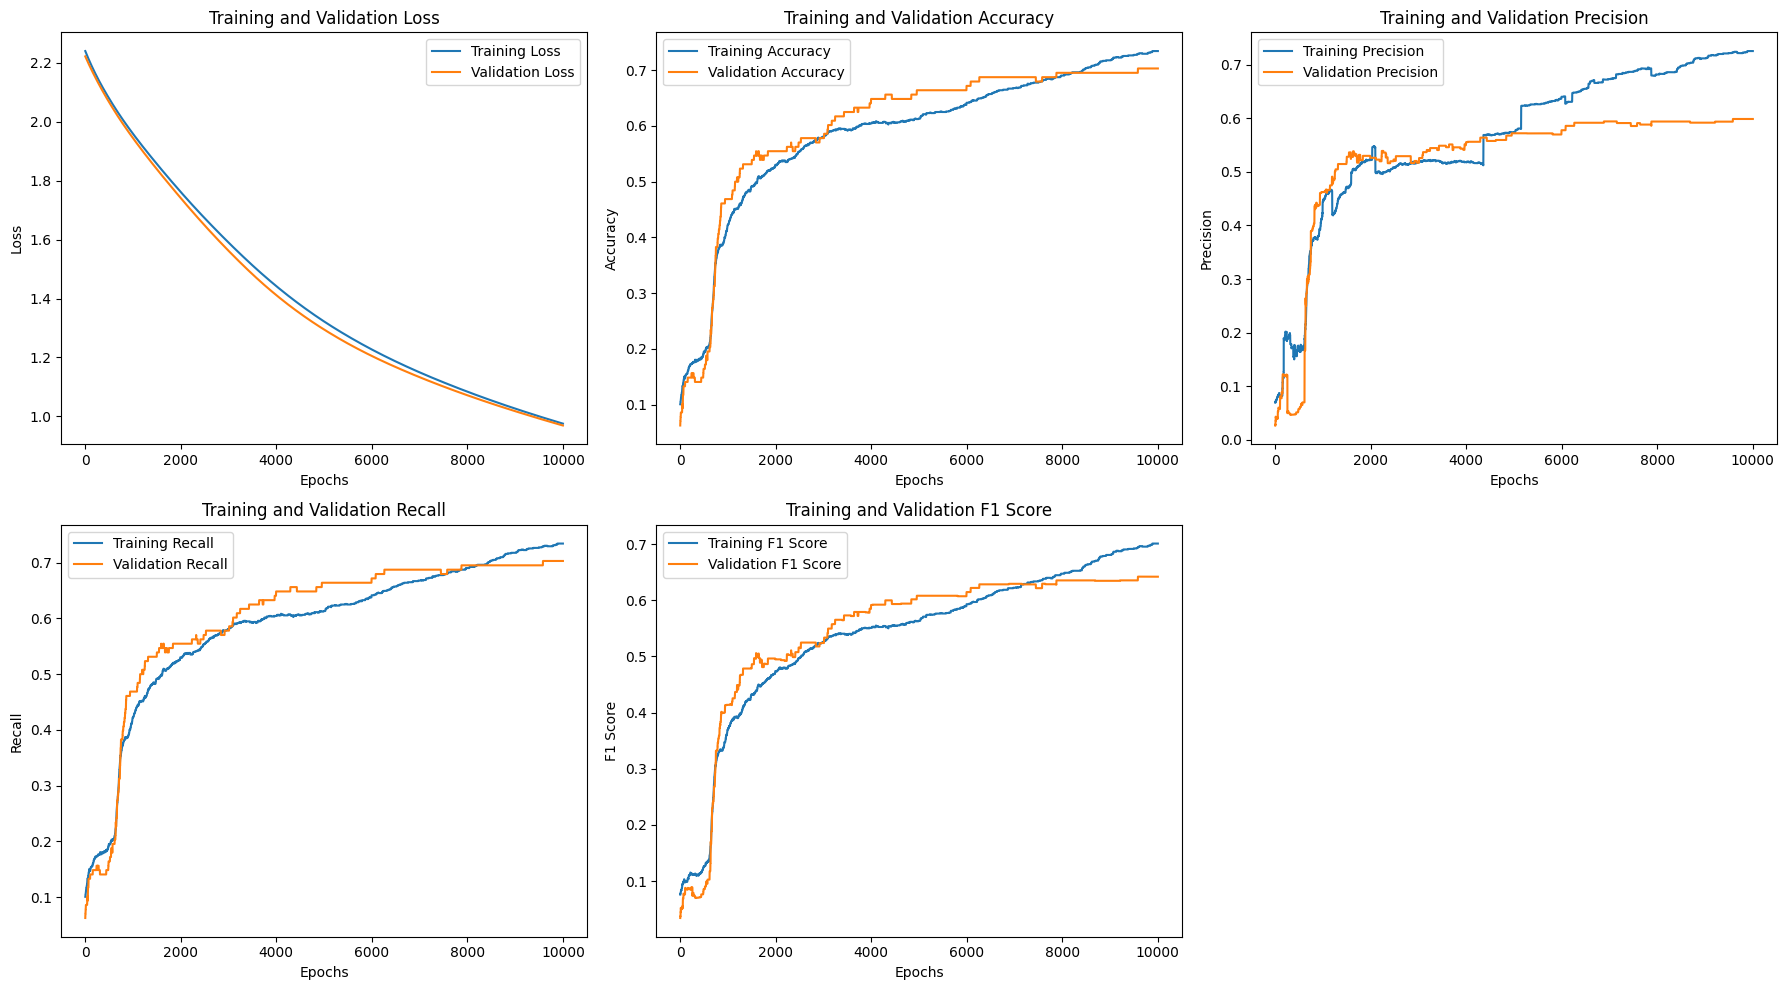

Accuracy: 0.6744
Precision: 0.4664
Recall: 0.4008
F1 Score: 0.3880


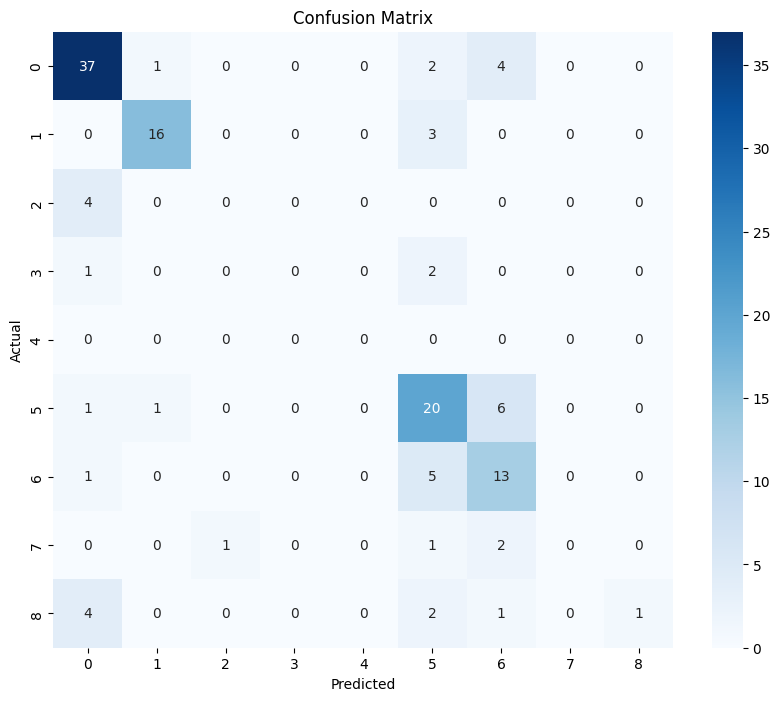

In [12]:
# Instantiate the model
model = MultiLayerPreceptron(input_size2, hidden_size2_1, hidden_size2_2, output_size2)

# Train the model
model.train(dataset.X_train,dataset.y_train,dataset.X_val,dataset.y_val, num_epochs=10000,lr=0.001)

# Evaluate the model
model.evaluate(dataset.X_test,dataset.y_test)

# layers=2, num_neurons=[128,128], lr=0.001

In [13]:
input_size3=dataset.X_train.shape[1]
hidden_size3_1=128
hidden_size3_2=128
output_size3=len(torch.unique(dataset.y_train))

0.001
Epoch [1000/10000], Loss: 1.9649
Epoch [2000/10000], Loss: 1.7526
Epoch [3000/10000], Loss: 1.5870
Epoch [4000/10000], Loss: 1.4511
Epoch [5000/10000], Loss: 1.3364
Epoch [6000/10000], Loss: 1.2394
Epoch [7000/10000], Loss: 1.1563
Epoch [8000/10000], Loss: 1.0841
Epoch [9000/10000], Loss: 1.0213
Epoch [10000/10000], Loss: 0.9662
Final Training Loss: 0.9662
Final Validation Loss: 0.9810
Final Training Accuracy: 0.7432
Final Validation Accuracy: 0.7109
Final Training Precision: 0.7383
Final Validation Precision: 0.6694
Final Training Recall: 0.7432
Final Validation Recall: 0.7109
Final Training F1 Score: 0.7196
Final Validation F1 Score: 0.6727


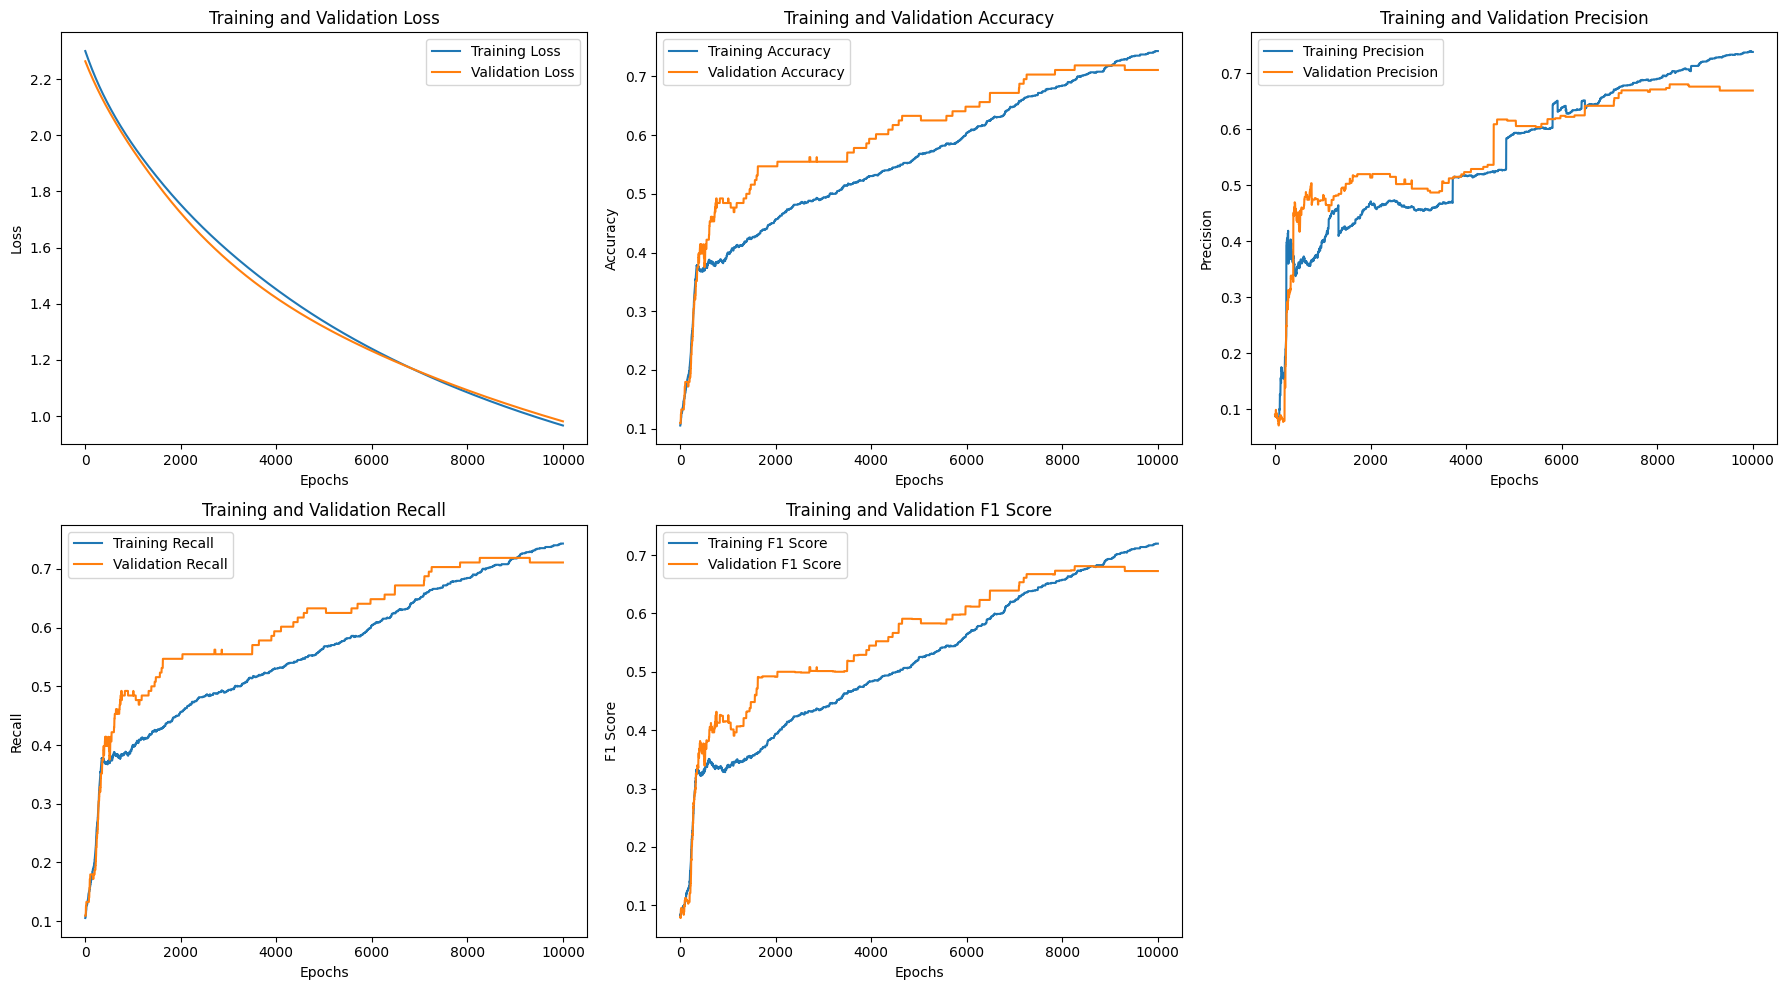

Accuracy: 0.6822
Precision: 0.4356
Recall: 0.4511
F1 Score: 0.4385


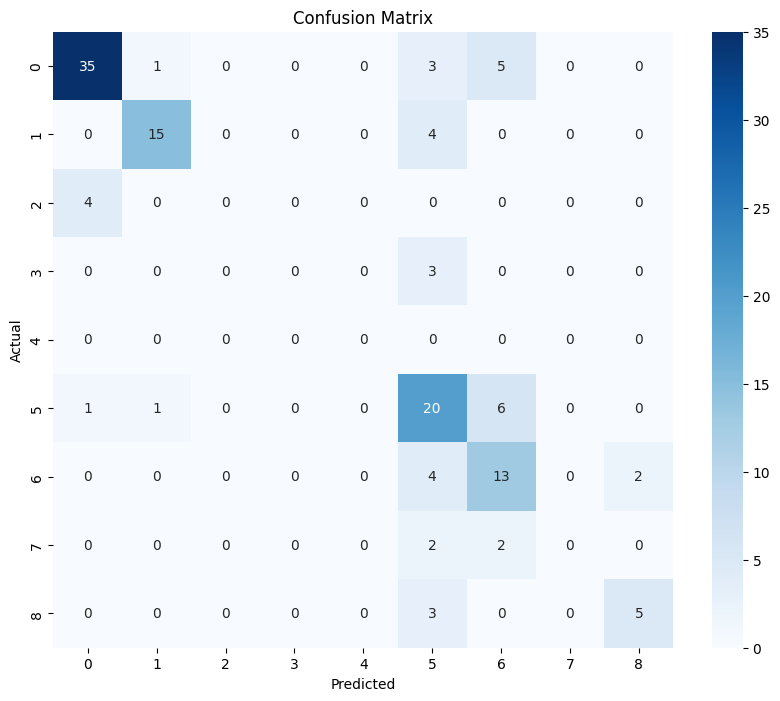

In [14]:
# Instantiate the model
model = MultiLayerPreceptron(input_size3, hidden_size3_1, hidden_size3_2, output_size3)

# Train the model
model.train(dataset.X_train,dataset.y_train,dataset.X_val,dataset.y_val, num_epochs=10000,lr=0.001)

# Evaluate the model
model.evaluate(dataset.X_test,dataset.y_test)

# Layers=3, num_neurons=[64,64,64],lr=0.001

In [15]:
input_size4=dataset.X_train.shape[1]
hidden_size4_1=64
hidden_size4_2=64
hidden_size4_3=64
output_size4=len(torch.unique(dataset.y_train))

0.001
Epoch [1000/10000], Loss: 2.1091
Epoch [2000/10000], Loss: 1.8364
Epoch [3000/10000], Loss: 1.5964
Epoch [4000/10000], Loss: 1.4227
Epoch [5000/10000], Loss: 1.2986
Epoch [6000/10000], Loss: 1.1935
Epoch [7000/10000], Loss: 1.0971
Epoch [8000/10000], Loss: 1.0208
Epoch [9000/10000], Loss: 0.9567
Epoch [10000/10000], Loss: 0.9004
Final Training Loss: 0.9004
Final Validation Loss: 0.8971
Final Training Accuracy: 0.7598
Final Validation Accuracy: 0.7188
Final Training Precision: 0.7227
Final Validation Precision: 0.6642
Final Training Recall: 0.7598
Final Validation Recall: 0.7188
Final Training F1 Score: 0.7326
Final Validation F1 Score: 0.6813


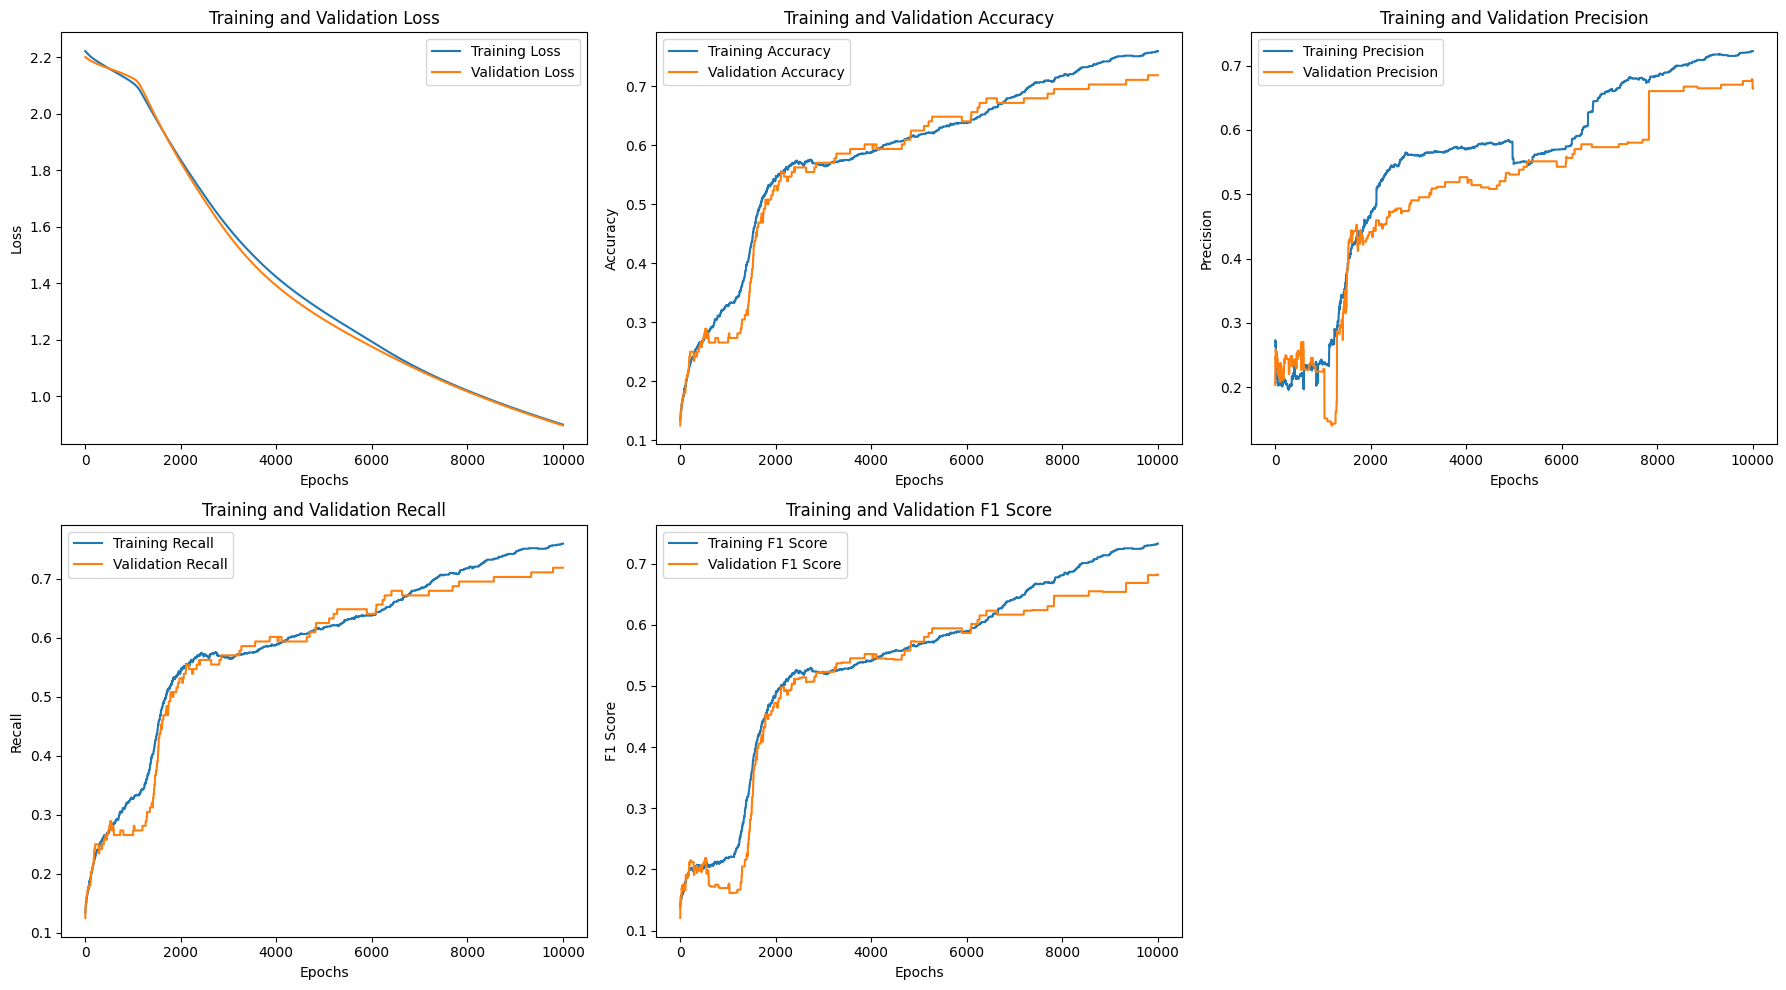

testing results
Accuracy: 0.6822
Precision: 0.4283
Recall: 0.4366
F1 Score: 0.4297


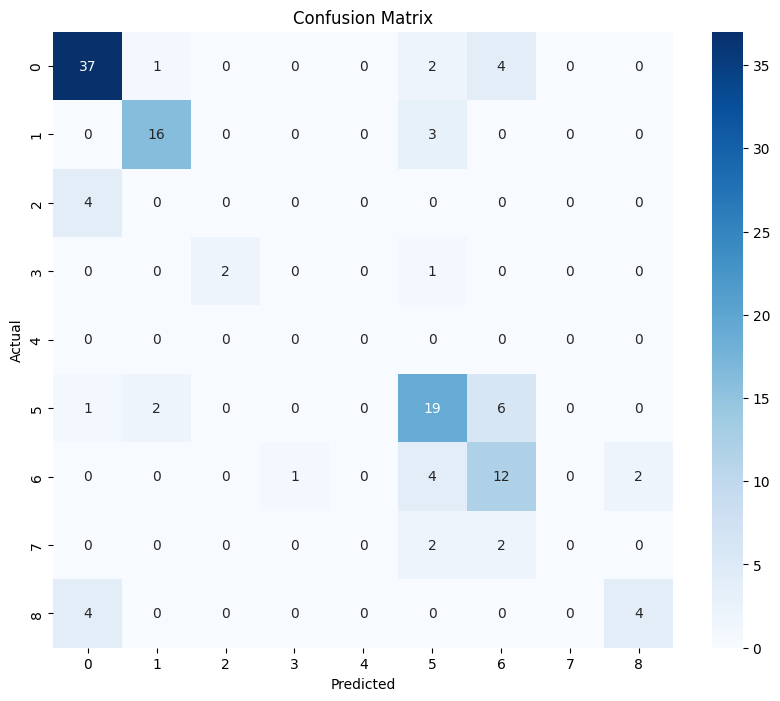

In [16]:
# Instantiate the model
model = MultiLayerPreceptron3(input_size4, hidden_size4_1, hidden_size4_2,hidden_size4_3, output_size4)

# Train the model
model.train(dataset.X_train,dataset.y_train,dataset.X_val,dataset.y_val, num_epochs=10000,lr=0.001)

# Evaluate the model
print("testing results")
model.evaluate(dataset.X_test,dataset.y_test)

# Layers=3, num_neurons=[64,32,32], lr=0.0001

In [17]:
input_size5=dataset.X_train.shape[1]
hidden_size5_1=64
hidden_size5_2=32
hidden_size5_3=32
output_size5=len(torch.unique(dataset.y_train))

0.0001
Epoch [1000/10000], Loss: 2.2609
Epoch [2000/10000], Loss: 2.2366
Epoch [3000/10000], Loss: 2.2176
Epoch [4000/10000], Loss: 2.2020
Epoch [5000/10000], Loss: 2.1887
Epoch [6000/10000], Loss: 2.1771
Epoch [7000/10000], Loss: 2.1668
Epoch [8000/10000], Loss: 2.1573
Epoch [9000/10000], Loss: 2.1483
Epoch [10000/10000], Loss: 2.1399
Final Training Loss: 2.1399
Final Validation Loss: 2.1448
Final Training Accuracy: 0.3301
Final Validation Accuracy: 0.2656
Final Training Precision: 0.1360
Final Validation Precision: 0.0885
Final Training Recall: 0.3301
Final Validation Recall: 0.2656
Final Training F1 Score: 0.1822
Final Validation F1 Score: 0.1321


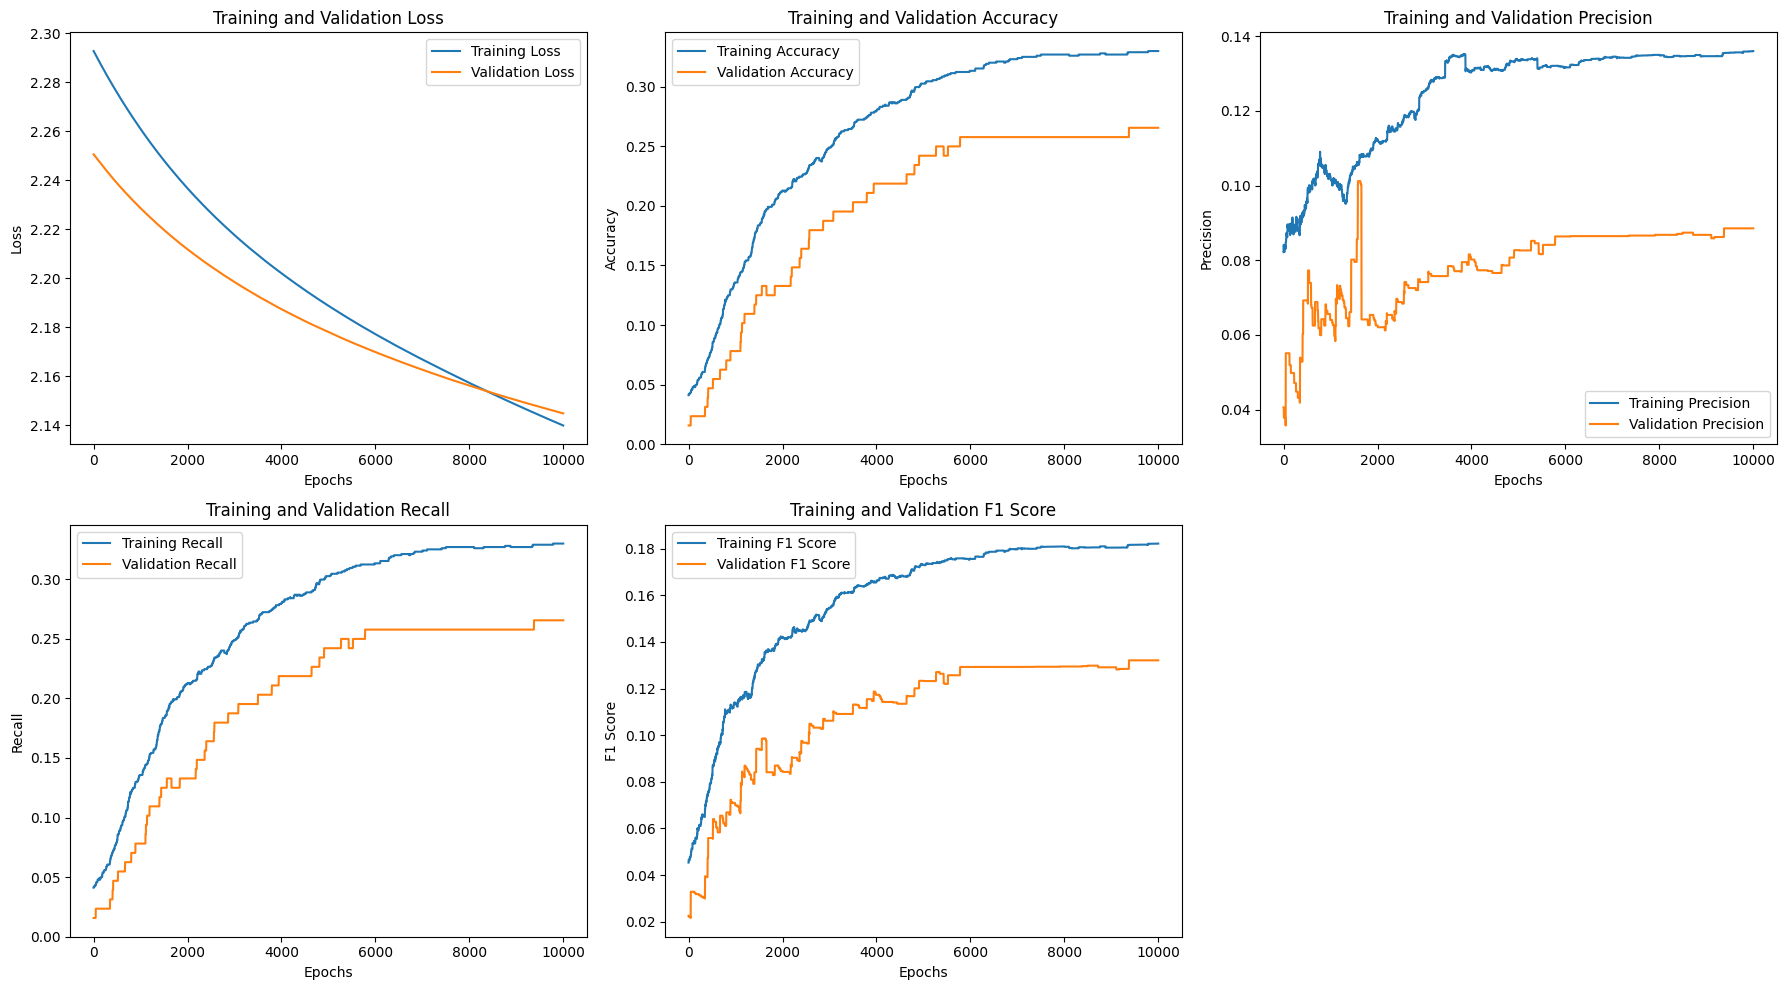

Accuracy: 0.2248
Precision: 0.0609
Recall: 0.1908
F1 Score: 0.0916


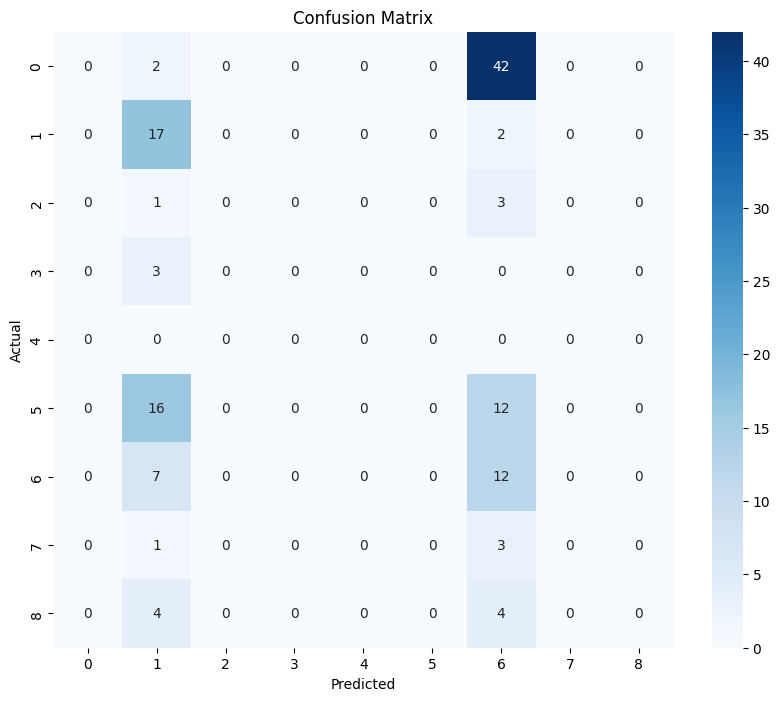

In [18]:
# Instantiate the model
model = MultiLayerPreceptron3(input_size5, hidden_size5_1, hidden_size5_2,hidden_size5_3, output_size5)

# Train the model
model.train(dataset.X_train,dataset.y_train,dataset.X_val,dataset.y_val, num_epochs=10000,lr=0.0001)

# Evaluate the model
model.evaluate(dataset.X_test,dataset.y_test)

# nn.module

In [19]:
class CustomDataset(Dataset):
    def __init__(self, dataset, target):
        self.data = dataset
        label_encoder = LabelEncoder()
        for column in self.data.columns:
            self.data[column] = label_encoder.fit_transform(self.data[column])
        self.features = torch.tensor(self.data.drop(columns=[target]).values, dtype=torch.float32)
        self.label = torch.tensor(self.data[target].values, dtype=torch.long)  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.features[idx], self.label[idx]

In [20]:
class nn_MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1,hidden_size_2, output_size):
        super(nn_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

In [21]:
class nn_MLP3(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3,output_size):
        super(nn_MLP3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_3, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [37]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            all_preds.append(predicted)
            all_labels.append(labels)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = correct / len(dataloader.dataset)
    precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
    recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
    conf_matrix = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    
  
    return total_loss / len(dataloader), accuracy, precision, recall, f1,conf_matrix

In [23]:
dataset2 = pd.read_csv("diagnosed_cbc_data_v4.csv")

custom_dataset = CustomDataset(dataset2, "Diagnosis")

train_size = int(0.8 * len(custom_dataset))
val_size = int(0.1 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# layers=2,num_neurons=[16,16],lr=0.01

In [35]:
input_size = custom_dataset.features.shape[1]
hidden_size_1 = 16
hidden_size_2 = 16
output_size = len(dataset2["Diagnosis"].unique())

Epoch [1000/10000], Loss: 1.1397, Val Loss: 1.3251, Val Accuracy: 0.5859
Epoch [2000/10000], Loss: 0.8720, Val Loss: 1.4092, Val Accuracy: 0.5859
Epoch [3000/10000], Loss: 0.9609, Val Loss: 1.4197, Val Accuracy: 0.5859
Epoch [4000/10000], Loss: 1.2765, Val Loss: 1.2950, Val Accuracy: 0.6016
Epoch [5000/10000], Loss: 0.7157, Val Loss: 1.3464, Val Accuracy: 0.6094
Epoch [6000/10000], Loss: 0.9246, Val Loss: 1.3773, Val Accuracy: 0.6016
Epoch [7000/10000], Loss: 0.7842, Val Loss: 1.4681, Val Accuracy: 0.6016
Epoch [8000/10000], Loss: 0.7537, Val Loss: 1.5250, Val Accuracy: 0.5859
Epoch [9000/10000], Loss: 0.8283, Val Loss: 1.6342, Val Accuracy: 0.6094
Epoch [10000/10000], Loss: 0.8279, Val Loss: 1.6582, Val Accuracy: 0.6016
Test Loss: 1.8184
Test Accuracy: 0.5969
Test Precision: 0.3558
 Test Recall: 0.4044
Test F1 Score: 0.3660


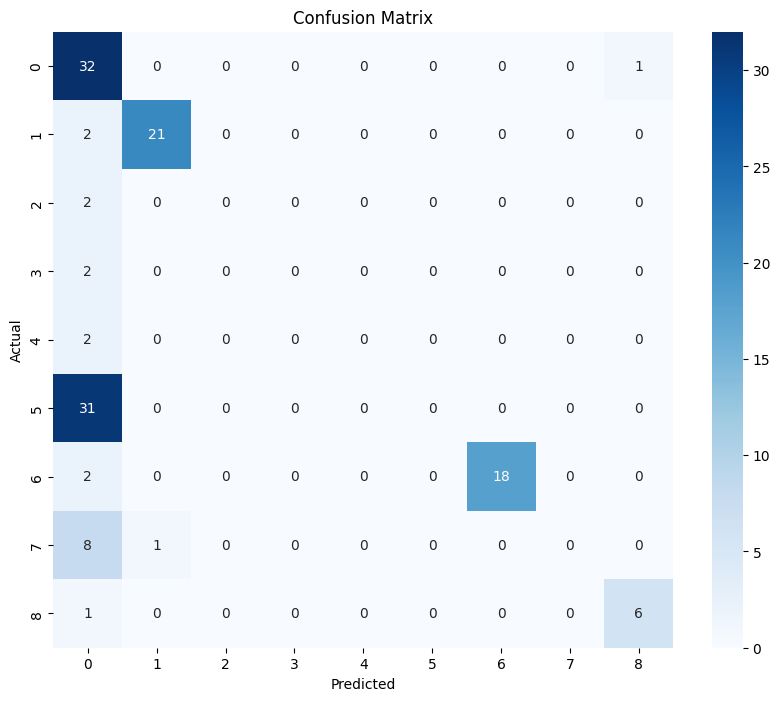

In [39]:
model = nn_MLP(input_size, hidden_size_1, hidden_size_2, output_size)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1000 == 0:
        val_loss, val_accuracy, val_precision, val_recall, val_f1,_ = evaluate(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy, test_precision, test_recall, test_f1,conf_matrix = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f" Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
    


# layers=2,num_neurons=[64,64],lr=0.01

In [40]:
hidden_size_1 = 64
hidden_size_2 = 64

Epoch [1000/10000], Loss: 1.1104, Val Loss: 2.2697, Val Accuracy: 0.5781
Epoch [2000/10000], Loss: 1.5205, Val Loss: 2.5574, Val Accuracy: 0.5703
Epoch [3000/10000], Loss: 1.4446, Val Loss: 2.7125, Val Accuracy: 0.5469
Epoch [4000/10000], Loss: 1.3648, Val Loss: 2.6368, Val Accuracy: 0.5547
Epoch [5000/10000], Loss: 1.4297, Val Loss: 2.6696, Val Accuracy: 0.5547
Epoch [6000/10000], Loss: 0.4710, Val Loss: 2.1512, Val Accuracy: 0.7578
Epoch [7000/10000], Loss: 0.2600, Val Loss: 2.2975, Val Accuracy: 0.7656
Epoch [8000/10000], Loss: 0.5199, Val Loss: 2.2083, Val Accuracy: 0.7812
Epoch [9000/10000], Loss: 0.3249, Val Loss: 2.5610, Val Accuracy: 0.7891
Epoch [10000/10000], Loss: 0.4549, Val Loss: 2.5488, Val Accuracy: 0.7656
Test Loss: 2.2423
Test Accuracy: 0.7132
Test Precision: 0.4089
 Test Recall: 0.4405
Test F1 Score: 0.4206


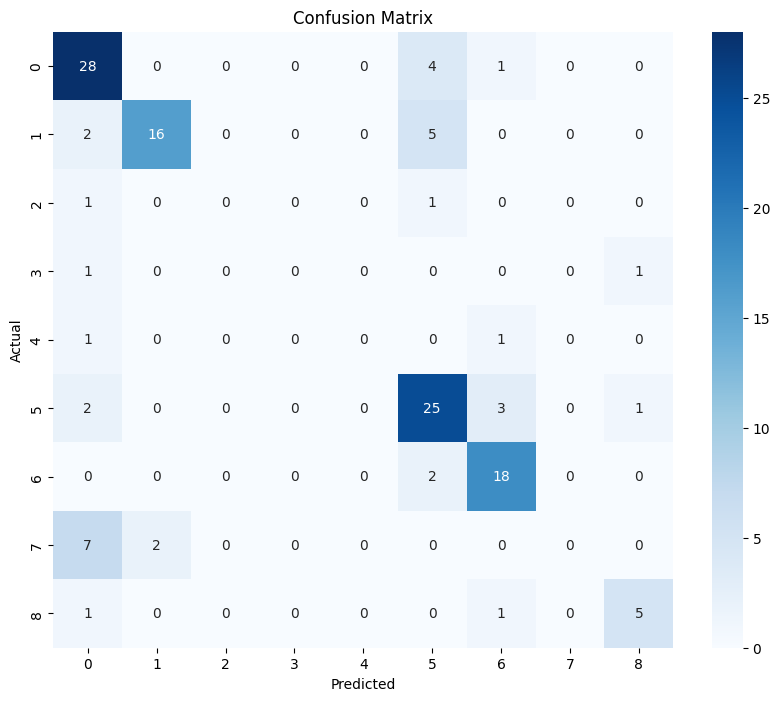

In [41]:
model = nn_MLP(input_size, hidden_size_1, hidden_size_2, output_size)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1000 == 0:
        val_loss, val_accuracy, val_precision, val_recall, val_f1 ,_= evaluate(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy, test_precision, test_recall, test_f1,conf_matrix = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f" Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# layers=2,num_neurons=[128,128],lr=0.001

In [42]:
hidden_size_1 = 128
hidden_size_2 = 128

Epoch [1000/10000], Loss: 3.2608, Val Loss: 3.6443, Val Accuracy: 0.5234
Epoch [2000/10000], Loss: 1.0691, Val Loss: 2.7966, Val Accuracy: 0.5859
Epoch [3000/10000], Loss: 0.1526, Val Loss: 1.5271, Val Accuracy: 0.8594
Epoch [4000/10000], Loss: 0.0006, Val Loss: 2.0279, Val Accuracy: 0.8594
Epoch [5000/10000], Loss: 0.0001, Val Loss: 1.8089, Val Accuracy: 0.8594
Epoch [6000/10000], Loss: 0.0759, Val Loss: 2.0625, Val Accuracy: 0.8750
Epoch [7000/10000], Loss: 0.0758, Val Loss: 1.9633, Val Accuracy: 0.8672
Epoch [8000/10000], Loss: 0.0759, Val Loss: 2.3394, Val Accuracy: 0.8438
Epoch [9000/10000], Loss: 0.0763, Val Loss: 2.7067, Val Accuracy: 0.8438
Epoch [10000/10000], Loss: 0.3033, Val Loss: 2.2435, Val Accuracy: 0.8516
Test Loss: 1.6912
Test Accuracy: 0.8450
Test Precision: 0.6388
 Test Recall: 0.6835
Test F1 Score: 0.6557


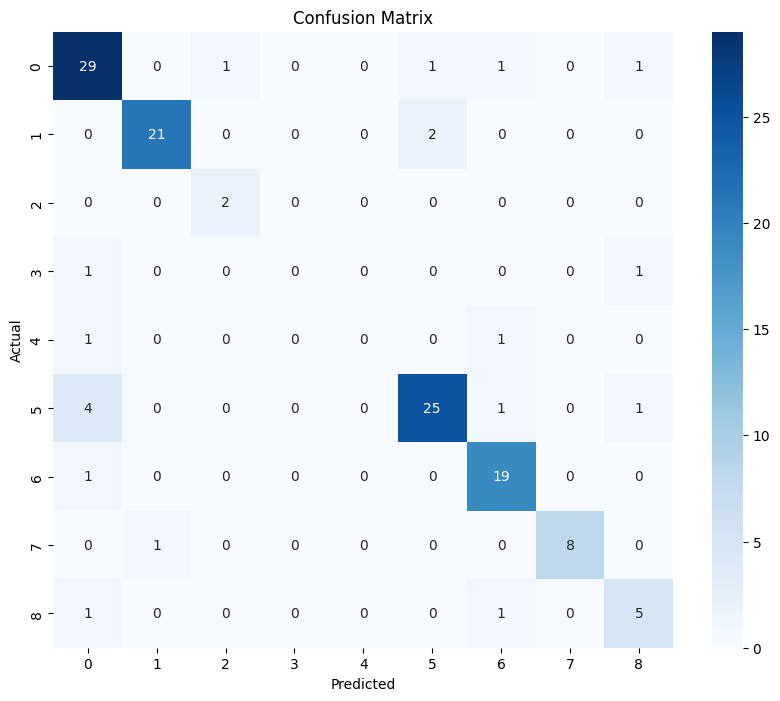

In [43]:
model = nn_MLP(input_size, hidden_size_1, hidden_size_2, output_size)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1000 == 0:
        val_loss, val_accuracy, val_precision, val_recall, val_f1,_ = evaluate(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy, test_precision, test_recall, test_f1,conf_matrix = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f" Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# layers=3,num_neurons=[64,,64,64],lr=0.01

In [44]:
hidden_size_1 = 64
hidden_size_2 = 64
hidden_size_3 = 64

Epoch [1000/10000], Loss: 0.0010, Val Loss: 1.0085, Val Accuracy: 0.8594
Epoch [2000/10000], Loss: 0.0306, Val Loss: 1.2140, Val Accuracy: 0.8516
Epoch [3000/10000], Loss: 0.0007, Val Loss: 1.2159, Val Accuracy: 0.8906
Epoch [4000/10000], Loss: 0.0000, Val Loss: 1.4070, Val Accuracy: 0.8828
Epoch [5000/10000], Loss: 0.0000, Val Loss: 2.0265, Val Accuracy: 0.8672
Epoch [6000/10000], Loss: 0.0000, Val Loss: 2.2171, Val Accuracy: 0.8672
Epoch [7000/10000], Loss: 0.0000, Val Loss: 1.9436, Val Accuracy: 0.8672
Epoch [8000/10000], Loss: 0.0000, Val Loss: 1.9144, Val Accuracy: 0.8516
Epoch [9000/10000], Loss: 0.0000, Val Loss: 2.4345, Val Accuracy: 0.8828
Epoch [10000/10000], Loss: 0.0000, Val Loss: 2.3297, Val Accuracy: 0.8672
Test Loss: 1.2444
Test Accuracy: 0.8527
Test Precision: 0.8937
 Test Recall: 0.8325
Test F1 Score: 0.8517


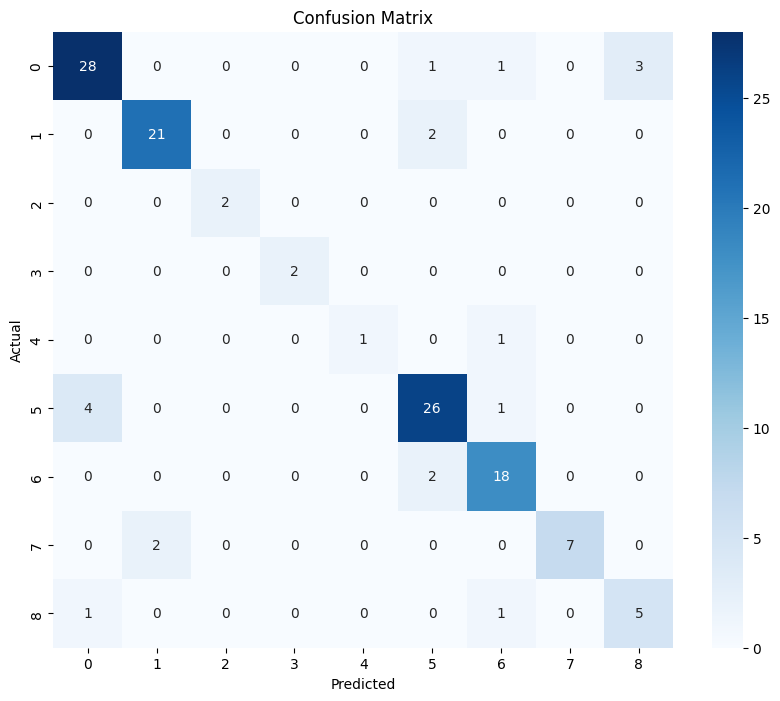

In [45]:
model = nn_MLP3(input_size, hidden_size_1, hidden_size_2, hidden_size_3,output_size)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1000 == 0:
        val_loss, val_accuracy, val_precision, val_recall, val_f1,_ = evaluate(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy, test_precision, test_recall, test_f1,conf_matrix = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f" Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# layers=3,num_neurons=[64,32,32],lr=0.0001

In [46]:
hidden_size_1 = 64
hidden_size_2 = 32
hidden_size_3 = 32

Epoch [1000/10000], Loss: 0.0173, Val Loss: 0.6439, Val Accuracy: 0.8594
Epoch [2000/10000], Loss: 0.0011, Val Loss: 1.6192, Val Accuracy: 0.8906
Epoch [3000/10000], Loss: 0.0002, Val Loss: 2.0227, Val Accuracy: 0.8828
Epoch [4000/10000], Loss: 0.0001, Val Loss: 2.1703, Val Accuracy: 0.8828
Epoch [5000/10000], Loss: 0.0001, Val Loss: 2.2903, Val Accuracy: 0.8828
Epoch [6000/10000], Loss: 0.0000, Val Loss: 2.3699, Val Accuracy: 0.8828
Epoch [7000/10000], Loss: 0.0000, Val Loss: 2.6198, Val Accuracy: 0.8828
Epoch [8000/10000], Loss: 0.0000, Val Loss: 2.6467, Val Accuracy: 0.8750
Epoch [9000/10000], Loss: 0.0000, Val Loss: 2.7293, Val Accuracy: 0.8750
Epoch [10000/10000], Loss: 0.0000, Val Loss: 2.8478, Val Accuracy: 0.8750
Test Loss: 1.9123
Test Accuracy: 0.8527
Test Precision: 0.8365
 Test Recall: 0.7198
Test F1 Score: 0.7527


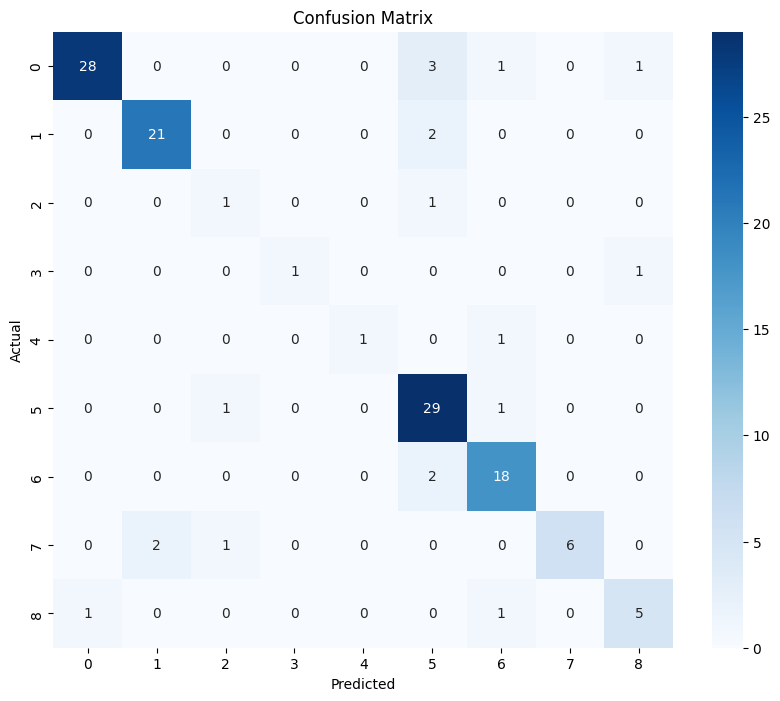

In [47]:
model = nn_MLP3(input_size, hidden_size_1, hidden_size_2, hidden_size_3,output_size)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1000 == 0:
        val_loss, val_accuracy, val_precision, val_recall, val_f1,_ = evaluate(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy, test_precision, test_recall, test_f1 ,conf_matrix= evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f" Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()